# Preprocessing pipeline

Even though Kaggle has worked to collect and ordered the data, the JSON files need some work before becoming trainable dataset

This will be organized in a three step process


P1 ==>
-  We will reduce the number of JSON files we will run on (1 in 100). This is to produce a more managable dataset as we are only testing the waters with our model. The full data can be reprocessed if the model is found to be good.
-  The info in CSVs will be brought in to become columns in panda dataset
-  We will split the dataset into two. One for each type of cell. As it would be easier to build a model predicting just code and just MarkDown. We could then use their output to train our full model

P2 ==>
- Tokens will be created from the markdowns and codes, with slightly different process
- features will be added (length of text, num of lines of code vs comments, dummy variables to replace left values - which should be encoded differently when it's a right value)

P3 ==>
- Vectorize the entry using `skikit-learn`

P4 ==>
- replace order of cells with comparison relations `{ <, =, > }`, creating n(n-1)/2 combinations
- Dataframes/ CSVs will be concatenated


Timing will be mandatory for long steps and recorded for purpose of optimizing re-running strategies




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_order = pd.read_csv("data/train_orders.csv")
train_order.cell_order=train_order.cell_order.str.split()
train_order.head(5)

,id,cell_order
0,00001756c60be8,"[1862f0a6, 448eb224, 2a9e43d6, 7e2f170a, 038b7..."
1,00015c83e2717b,"[2e94bd7a, 3e99dee9, b5e286ea, da4f7550, c4172..."
2,0001bdd4021779,"[3fdc37be, 073782ca, 8ea7263c, 80543cd8, 38310..."
3,0001daf4c2c76d,"[97266564, a898e555, 86605076, 76cc2642, ef279..."
4,0002115f48f982,"[9ec225f0, 18281c6c, e3b6b115, 4a044c54, 365fe..."


In [3]:
df1 = pd.read_json("data/train/00001756c60be8.json")

In [4]:
vort = "train" # validation or training

## Step P1: Skim dataset and add order information

At this stage, only one in 1000 notebooks is processed. After all notebooks are finished, this is re-run at a higher skim rate (currently at 1 in 30). We also need a manual validation set, as we don't want the same document to be feeding into both training and validation

In [5]:
%%time
#  time: 5sec / memory: 4MB
for index, row in train_order.iterrows():
    validationindex = index%5000 == 137
    if index%30==0 or validationindex:
        true_order = { h: i for i, h in enumerate(row["cell_order"])}

        # get dataframe
        df = pd.read_json(f"data/train/{row['id']}.json")
        df.loc[:,"true_order"] = df.index.map(true_order)
        df_code = df[df.cell_type=="code"].copy()
        df_md = df[df.cell_type=="markdown"].copy()
        df_code.loc[:,"true_order_code"] = df_code["true_order"].rank(method="min").map(int)
        df_md.loc[:,"true_order_md"] = df_md["true_order"].rank(method="min").map(int)
        df_code = df_code.sample(frac=1).reset_index(drop=True)
        #df.to_csv(f"data/train_P1/{row['id']}.csv")
        #df.to_json(f"data/train_P1/{row['id']}.json")
        if validationindex:
            df_code.to_csv(f"data/valid_P1_code/{row['id']}.csv")
            df_code.to_json(f"data/valid_P1_code/{row['id']}.json")
            df_md.to_csv(f"data/valid_P1_md/{row['id']}.csv")
            df_md.to_json(f"data/valid_P1_md/{row['id']}.json")
        else:
            df_code.to_csv(f"data/train_P1_code/{row['id']}.csv")
            df_code.to_json(f"data/train_P1_code/{row['id']}.json")
            df_md.to_csv(f"data/train_P1_md/{row['id']}.csv")
            df_md.to_json(f"data/train_P1_md/{row['id']}.json")
df.sample(5)
        

CPU times: user 15.9 s, sys: 1.63 s, total: 17.5 s
Wall time: 19.1 s


,cell_type,source,true_order
7c61467b,code,"train_df = data[['Weight', 'Balance']].dropna(...",49
7effe576,code,"fig = plt.figure(figsize=(5,5))\nsns.distplot(...",37
b099b3a5,code,df[numerical_features].describe().T,18
ca61ed24,code,import numpy as np \nimport pandas as pd\nimpo...,3
9b9d3eab,markdown,## As all the Numerical features are been impu...,61


## Pipeline decorator

Write a decorator that encapsulates the process of opening files, performing transformations and saving them
This is less efficient in terms of storage, but since I am running on my laptop, this helps save CPU time - You don't need to re-run everything everytime you make a change

In [6]:
import os
from random import shuffle
# this configures and returns the decorator
def pipeline(indir, outdir=None, breakafterone = False):

    # the decorator only receives the function and nothing else
    def pipelinedecor(funct):

        ## this will take the function and run it
        def pipelineinner(df, *args, **kwargs):
            df_ = df
            infiles = os.listdir(indir)

            for f in infiles:

                if os.path.isfile(indir+f):
                    fn_ = f.split(".")

                    
                    if fn_[1]=="json":
                        # df is just a dummy variable 
                        # as we will give it our own input and output
                        
                        df = pd.read_json(indir+ f"{fn_[0]}.json")
                        # main function
  
                        df =  funct(df, *args, **kwargs)

                        if outdir and df is not None:
                            #df.to_csv(outdir+ f"{fn_[0]}.csv")  # at this point csv is used for human verification
                            df.to_json(outdir+ f"{fn_[0]}.json")

                        if breakafterone:
                            break

            return df_ # return the dummy variable unchanged
        return pipelineinner  
    return pipelinedecor
    

## Step P2: NLP preprocessing

Markdown is transformed with common NLP preprocessing techniques

lower case, remove html tags (as markdown is html compatible), remove non-alphabetical characters,
remove digits

The markdown is then tokenized and further words are dropped if they are stop words, is digit number (unfortunately this sometimes remove chapter number which would be useful - opportunity for feature engineering), having length more than 20 characters (usually these are hashes)

Lastly the words pass through a stemmer to remove grammatical conjugations which confuses the computer

In [7]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import ngrams, FreqDist

extra_stopwords = ["li", "br", "http", "https", "www", "com", "class", "alert"]
re_html = re.compile(r'<[^>]+>')
re_char = re.compile(r"[^a-zA-Z0-9]")

def preprocessing_unit(sourcetext: str):
    words = sourcetext.lower()
    words = re_html.sub('', words)
    words = re_char.sub(' ', words)
    words=nltk.word_tokenize(words)
    words=[w for w in words if w not in stopwords.words("english") + extra_stopwords]
    words = [w for w in words if not w.isdigit()]
    words = [w for w in words if len(w)<20]
    words = [PorterStemmer().stem(w) for w in words]
    
    
    return words

### AST Unit

The AST unit generates left and right values, which is used in different ways

1. we get a list of variables, which might be replaced by dummy variable for training
2. we may build a directed graph which could help establish inheritance. These are strong features even as some authors of these notebooks are error-prone

In [8]:
import ast
re_nomagic = re.compile(r"^[!%].*\n?", flags=re.MULTILINE) # remove ipython magic (syntax error)

def ast_unit(sourcetext):

    sourcetext =  re_nomagic.sub(" ", sourcetext.lower())
    
    try:
        root = ast.parse(sourcetext)
    except SyntaxError as e: 
        # This is unavoidable as we cannot control what 
        # authors of notebook put into their coding cells
        # and at this point AST dosn't have a good way to 
        # recover from an error
        return ([],[])

    # all use of variables
    all_vars = {node.id for node in ast.walk(root) if isinstance(node, ast.Name)}
    
    # left values
    # currently only direct assignment of simple variables are 
    assignment = {n.id                      for node in ast.walk(root) \
                                            if isinstance(node, ast.Assign) \
                                            for n in node.targets\
                                            if isinstance(n, ast.Name) }


    all_imports =  {n.asname or n.name  for node in ast.walk(root) \
                                    if isinstance(node, (ast.Import, ast.ImportFrom)) \
                                    for n in node.names} 
 
    right_values = all_vars-assignment-all_imports
    left_values = assignment | all_imports
    return list(left_values), list(right_values)

source = "import pandas as pd \nfrom imblearn.over_sampling import "\
         "RandomOverSampler, SMOTE \nimport matplotlib; x = "\
         "train_df.drop(columns = \"target\", random_seed=seed)"
 
ast_unit(source)

(['x', 'smote', 'randomoversampler', 'pd', 'matplotlib'], ['train_df', 'seed'])

In [9]:
testphrase = df1.iloc[-2]["source"]
print(testphrase, " ==> ", preprocessing_unit(testphrase))
testphrase = df.iloc[-2]["source"]
print(testphrase, " ==> ", preprocessing_unit(testphrase))

Инициализация класса Data  ==>  ['data']
The club has no relation with the other features and imputing it wiht any club names will be bias. So i am imputing it with the 'no Club'. We can also see there is an line showing missing values in rows of different features both categorical and numerical. So let's view categorical and numerical variable seperately  ==>  ['club', 'relat', 'featur', 'imput', 'wiht', 'club', 'name', 'bia', 'imput', 'club', 'also', 'see', 'line', 'show', 'miss', 'valu', 'row', 'differ', 'featur', 'categor', 'numer', 'let', 'view', 'categor', 'numer', 'variabl', 'seper']


### Applying transformation
This applies the preprocessing and AST units above

In [10]:
%%time

all_codetokens_in_all_nbs = []
#@pipeline("data/train_P1_code/","data/train_P2_code/", breakafterone=False)
@pipeline(f"data/{vort}_P1_code/",f"data/{vort}_P2_code/")
def P2_code(df, all_codetokens_in_all_nbs):

    ## AST TREE
    df["codetokens"] = df["source"].apply(ast_unit)

    all_codetokens_in_nb = df["codetokens"].apply(lambda x: x[0]+x[1]).sum()
    df.loc[:, "L-codetokens"] = df.apply(lambda x: x.codetokens[0], axis =1)
    df.loc[:, "R-codetokens"] = df.apply(lambda x: x.codetokens[1], axis =1)


    ## Ordinary text analysis
    df["tokens"] = df["source"] .apply(preprocessing_unit)
    
    all_tokens_in_nb = df["tokens"].apply(lambda x: " ".join(x))
    all_codetokens_in_all_nbs += all_codetokens_in_nb

    return df


# 23sec/8MB for 0.1% data
# input/ output is just dummy variable
_ = P2_code( _,      all_codetokens_in_all_nbs)

CPU times: user 7min 5s, sys: 52 s, total: 7min 57s
Wall time: 8min 2s


In [11]:
%%time
all_tokens_in_all_nbs = []
#@pipeline("data/train_P1_md/","data/train_P2_md/", breakafterone=False)
@pipeline(f"data/{vort}_P1_md/",f"data/{vort}_P2_md/")
def P2_md(df, all_tokens_in_all_nbs):
    df["tokens"] = df["source"].apply(preprocessing_unit)
    
    all_tokens_in_nb = df.tokens.apply(lambda x: " ".join(x))
    all_tokens_in_all_nbs += all_tokens_in_nb.tolist()
    return df

#8sec/8MB for 0.1% data
# input/ output is just dummy variable
_ = P2_md("dummy",  all_tokens_in_all_nbs) 

CPU times: user 2min 27s, sys: 19.6 s, total: 2min 46s
Wall time: 2min 48s


In [12]:
print(FreqDist(all_tokens_in_all_nbs).most_common(30))

[('', 1942), ('model', 371), ('import librari', 284), ('load data', 218), ('exploratori data analysi', 199), ('train', 186), ('featur engin', 173), ('logist regress', 168), ('eda', 164), ('predict', 163), ('train model', 149), ('submiss', 140), ('data preprocess', 137), ('import', 125), ('random forest', 118), ('read data', 113), ('imag png attach imag png', 112), ('conclus', 111), ('preprocess', 99), ('load dataset', 99), ('visual', 96), ('data clean', 93), ('decis tree', 90), ('train test split', 88), ('dataset', 84), ('import data', 83), ('data visual', 83), ('xgboost', 81), ('introduct', 79), ('data', 77)]


In [13]:
all_counts = dict()
for size in 1, 2, 3, 4, 5:
    all_counts[size] = FreqDist(ngrams(all_tokens_in_all_nbs, size))
# No Ngrams for code
all_code_counts = FreqDist(all_codetokens_in_all_nbs)

## P2A: Plotting

Now checking the overall frequecy of words

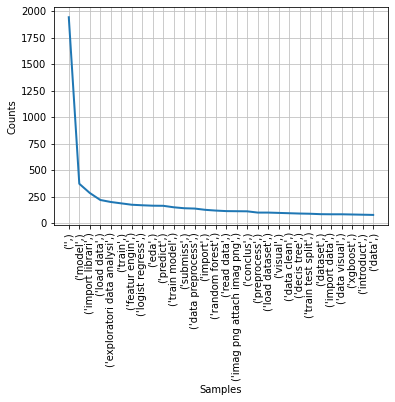

In [14]:
ax = all_counts[1].plot(30)

In [15]:
all_counts[1].most_common(10)

[(('',), 1942),
 (('model',), 371),
 (('import librari',), 284),
 (('load data',), 218),
 (('exploratori data analysi',), 199),
 (('train',), 186),
 (('featur engin',), 173),
 (('logist regress',), 168),
 (('eda',), 164),
 (('predict',), 163)]

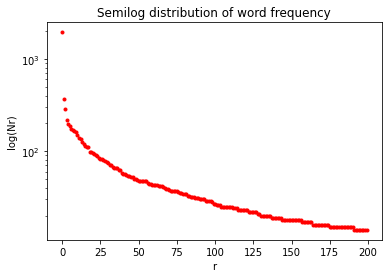

In [16]:
#print( all_counts[1].most_common(30))
log_rvsNr = [(key,value) for((key,), value) in all_counts[1].most_common(200) ]
log_rvsNr = list(zip(*log_rvsNr))

# plot the graph of log(r) vs log(Nr)
plt.semilogy(range(len(log_rvsNr[0])), log_rvsNr[1], 'r.')
plt.xlabel('r')
plt.ylabel('log(Nr)')
#plt.set_xticks(range(len(log_rvsNr[0])))
#plt.set_xticklabels(log_rvsNr[0])
plt.title('Semilog distribution of word frequency')
plt.show()

In [17]:
for ng, ngcount in all_counts[1].most_common(25):
    print(" ".join(ng), ngcount)

 1942
model 371
import librari 284
load data 218
exploratori data analysi 199
train 186
featur engin 173
logist regress 168
eda 164
predict 163
train model 149
submiss 140
data preprocess 137
import 125
random forest 118
read data 113
imag png attach imag png 112
conclus 111
preprocess 99
load dataset 99
visual 96
data clean 93
decis tree 90
train test split 88
dataset 84


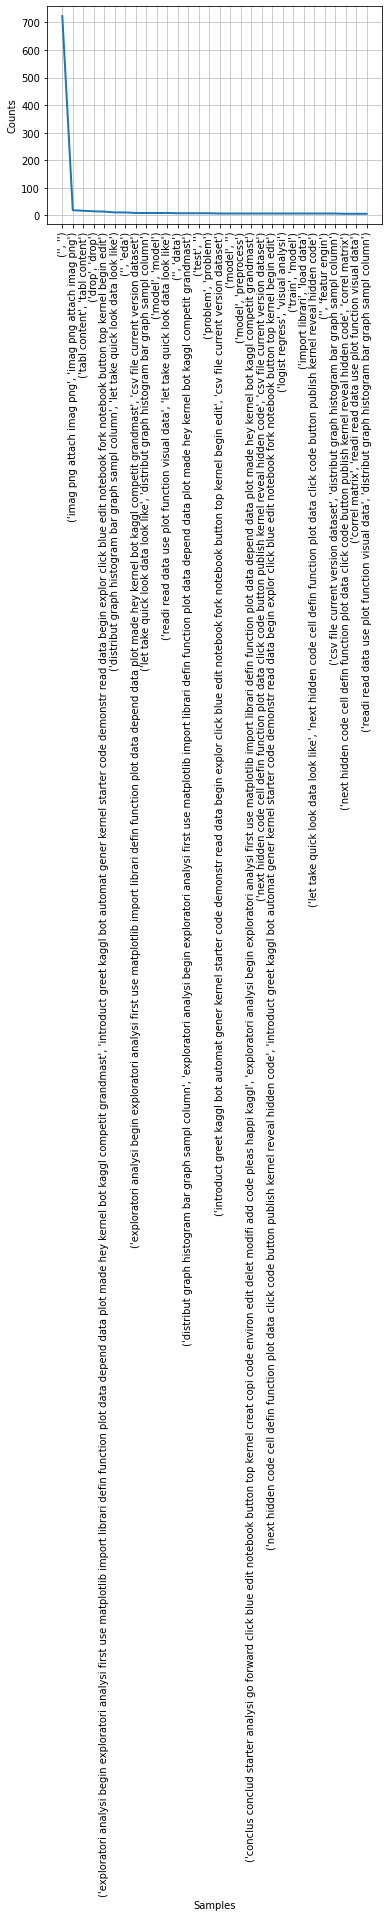

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [18]:
all_counts[2].plot(30)

In [19]:
for size in 2,3:
    for ng, ngcount in all_counts[size].most_common(10):
        print(" ".join(ng), ngcount)

  723
imag png attach imag png imag png attach imag png 18
tabl content tabl content 16
drop drop 14
exploratori analysi begin exploratori analysi first use matplotlib import librari defin function plot data depend data plot made hey kernel bot kaggl competit grandmast introduct greet kaggl bot automat gener kernel starter code demonstr read data begin explor click blue edit notebook fork notebook button top kernel begin edit 13
distribut graph histogram bar graph sampl column let take quick look data look like 10
 eda 10
exploratori analysi begin exploratori analysi first use matplotlib import librari defin function plot data depend data plot made hey kernel bot kaggl competit grandmast csv file current version dataset 8
let take quick look data look like distribut graph histogram bar graph sampl column 8
model model 8
   392
drop drop drop 13
imag png attach imag png imag png attach imag png imag png attach imag png 8
  data 5
  eda 4
submiss   4
data   4
dcgan   4
tabl content tabl 

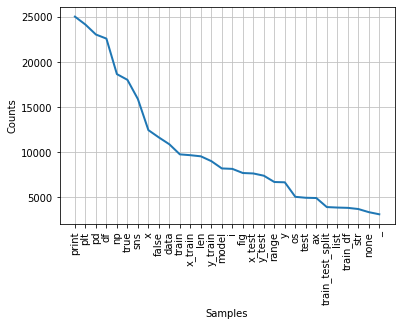

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [20]:
all_code_counts.plot(30)

In [21]:
for ng, ngcount in all_code_counts.most_common(200):
    print(ng, ngcount)

print 25046
plt 24163
pd 23057
df 22604
np 18659
true 18027
sns 15889
x 12438
false 11625
data 10864
train 9745
x_train 9652
len 9527
y_train 8991
model 8182
i 8133
fig 7674
x_test 7624
y_test 7374
range 6675
y 6641
os 5028
test 4923
ax 4896
train_test_split 3891
list 3837
train_df 3803
str 3674
none 3326
_ 3088
y_pred 2988
int 2787
df_train 2696
tf 2629
enumerate 2407
dataset 2378
torch 2254
dict 2204
f 2176
train_data 2108
accuracy_score 2092
px 2071
filename 2031
confusion_matrix 2013
col 1943
image 1927
go 1807
filenames 1799
test_df 1752
round 1716
dirname 1690
labels 1633
batch_size 1588
classification_report 1581
df_test 1520
zip 1464
history 1460
randomforestclassifier 1446
logisticregression 1440
standardscaler 1407
self 1358
k 1348
dense 1345
predictions 1274
tqdm 1256
gridsearchcv 1229
features 1208
a 1201
img 1199
path 1180
cross_val_score 1177
mean_squared_error 1169
c 1164
metrics 1149
n 1142
j 1123
sequential 1109
warnings 1106
clf 1104
cv2 1101
test_data 1093
p 1079
re 

## Step P3: Vectorizing

Several options: one-hot encoding, TF-IDF (document defined as cells, as that is the unit we want to measure the )

### An array of all sentences/ lines of code

In [22]:
%%time
## This creates list of sentences for all notebooks so as to be fed into scikit vectorizers

#just a trick to make sure the pipeline produce side-effects
sentences_in_all_nbs = [pd.Series([])]

@pipeline("data/train_P2_md/", None) # NOTE: validation set should still take encoding of 
def P3A_md(df, sentences_in_all_nbs):

    sentences = df.loc[:, "tokens"].map(lambda x: " ".join(x))
    sentences_in_all_nbs[0] = pd.concat([sentences_in_all_nbs[0], sentences])
    return df

# 0.5 sec for 0.1% data
_ = P3A_md("dummy", sentences_in_all_nbs) 
# input/ output is just dummy variable
sentences_in_all_nbs=sentences_in_all_nbs[0]

<timed exec>:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


CPU times: user 12.2 s, sys: 548 ms, total: 12.8 s
Wall time: 13 s


In [23]:
%%time
codesentences_in_all_nbs = [pd.Series([])]

@pipeline("data/train_P2_code/", None)
def P3A_code(df, codesentences_in_all_nbs):
    codesentences = df.loc[df.codetokens.values != None, "codetokens"]\
                                .map(lambda x: " ".join(x[0]+x[1]))
    codesentences_in_all_nbs[0] = pd.concat([codesentences_in_all_nbs[0], codesentences])
    return df

# 1 sec for 0.1% data
_ = P3A_code("dummy", codesentences_in_all_nbs) 
# input/ output is just dummy variable
codesentences_in_all_nbs = codesentences_in_all_nbs[0]

<timed exec>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


CPU times: user 12.9 s, sys: 453 ms, total: 13.3 s
Wall time: 13.8 s


In [24]:
sentences_in_all_nbs

d822de37                                verifi year sinc join
c63e2a26    final task want know year sinc join field accu...
c6fc6d48                                pleas upvot find help
134bc533    want keep aveng introduc filter aveng introduc...
d0ed365b                                       consolid death
                                  ...                        
4752a503                         exploratori data analysi eda
daa462c3                                             get data
7f6dad67                                           train data
35800b91    encrypt tbn0 gstatic imag q tbn y6tww usqp cau...
7d1724a1                                    spoiler miss valu
Length: 87498, dtype: object

## TF-IDF Vectorizer

Two different vectorizers are used for code and markdown respectively. As code tokens are more repetitive, one-hot coding is used. On the other hand TF-IDF is used for markdown. Note that the unit of document is each markdown cell, as that is the unit we need to measure against.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfVectorizer

# Now setup TF-IDF vectorizor 

tfidf_vectorizer = TfidfVectorizer(min_df=0.01)
tfidf_vectorizer.fit(sentences_in_all_nbs)

print("length of TF-IDF vector", len(tfidf_vectorizer.get_feature_names_out()))
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names_out(),columns=["idf_weights"]) 
#df_idf.sort_values(by=['idf_weights'])
#print(df_idf.sort_values(by=['idf_weights']))

# try transforming one line
vectors_tfidf = tfidf_vectorizer.transform(sentences_in_all_nbs)


length of TF-IDF vector 229


In [26]:
# One hot vectorizor for code (as they are much more repetitive)
vectorizer_code = CountVectorizer(max_features = 250)
vectors_code = vectorizer_code.fit_transform(codesentences_in_all_nbs)
print("length of code one-hot vector", len(vectorizer_code.get_feature_names_out()))

length of code one-hot vector 250


In [27]:
df = pd.DataFrame(vectors_tfidf[0].T.todense(),
                    index=tfidf_vectorizer.get_feature_names_out(),
                    columns=["TF-IDF"]) 
df.sort_values(by=["TF-IDF"],ascending=False)

,TF-IDF
sinc,0.715380
year,0.698736
origin,0.000000
output,0.000000
paramet,0.000000
...,...
group,0.000000
help,0.000000
high,0.000000
higher,0.000000


In [28]:
print("How full is the sparse array?",
      np.count_nonzero(vectors_code.toarray())/vectors_code.shape[0]/vectors_code.shape[1])

How full is the sparse array? 0.010809631193996016


In [29]:
vectors_code 

<167622x250 sparse matrix of type '<class 'numpy.int64'>'
	with 452983 stored elements in Compressed Sparse Row format>

In [30]:
vectors_tfidf

<87498x229 sparse matrix of type '<class 'numpy.float64'>'
	with 451386 stored elements in Compressed Sparse Row format>

### processing

In [31]:
# apped two arrays, we now have double the features
np.append(vectors_code.toarray(),vectors_code.toarray(),axis=1).shape

(167622, 500)

In [32]:
df = pd.read_json("data/train_P2_code/0b1de3720f4773.json")
#df

In [33]:
def add_features(df):
    length = df.tokens.map(len)
    df["length"] = length
add_features(df)
#df

In [34]:
%%time

@pipeline(f"data/{vort}_P2_code/", f"data/{vort}_P3_code/", breakafterone=False)
def P3_code(df):

    # for adding features
    #additional_features = add_features(df)

    vector_code = vectorizer_code.transform(df.tokens.apply(lambda l: " ".join(l)))
    array_code = vector_code.toarray()
    df["encoding"] = array_code.tolist() #+ additional_features
    return df

#df = pd.read_json("data/train_P2_code/0b1de3720f4773.json")
#df = P3_code(df) #FIXME test

# 0.9 sec for 0.1% data
_ = P3_code("dummy") 

CPU times: user 14.3 s, sys: 754 ms, total: 15.1 s
Wall time: 15.6 s


In [35]:
%%time

@pipeline(f"data/{vort}_P2_md/", f"data/{vort}_P3_md/", breakafterone=False)
def P3_md(df):

    # for adding features
    #additional_features = add_features(df)

    vector_md = tfidf_vectorizer.transform(df.tokens.apply(lambda l: " ".join(l)))
    array_md = vector_md.toarray()
    df["encoding"] = array_md.tolist() #+ additional_features
    return df

#df = pd.read_json("data/train_P2_md/0b1de3720f4773.json")
#df = P3_md(df) #FIXME test

# 0.9 sec for 0.1% data
_ = P3_md("dummy") 
#df

CPU times: user 12.4 s, sys: 625 ms, total: 13 s
Wall time: 13.4 s


 ## Step P4: create pairings

We must now pair entries from the same notebook, and add all possible combinations

We also add final set of features that comes out of comparison of any two entries

Ancestry of python variables are now determined solely by comparing L- and R- values

Earlier, this step outputs csv and json like any other, but it turns out this is very


In [36]:
from scipy.sparse import csr_matrix, coo_matrix, hstack, vstack, save_npz
from functools import reduce
from itertools import combinations
from array import array

In [37]:
def ancestry(x):
    ## determine ancestry
    # a variable must first appear as an L value before R value
    # therefore L value should have precedence
    # so if the L value in A appears in B, it suggests A is first 
    # (although there is a chance that this is a typo)
    # This implementation counts the number of times this occur
    x["A_first"] = sum([tok in x["R-codeB"] for tok in x["L-codeA"]])
    x["B_first"] = sum([tok in x["R-codeA"] for tok in x["L-codeB"]])
    return array('f',[x["A_first"], x["B_first"]])

In [38]:
%%time
dataset_code = {"x":[], "y": []}
#df = pd.read_json("data/train_P3_code/cbf92bdb8acdb1.json")
#@pipeline("data/train_P3_code/", "data/train_P4_code/", breakafterone=False)
@pipeline(f"data/{vort}_P3_code/", None, breakafterone=False)
def P4_code(df):
    if df.shape[0]==1: 
        return None

   
    a, b = map(list, zip(*combinations(df.index, 2)))

    df_new = pd.DataFrame(data={"encodingA":df.loc[a,"encoding"].reset_index(drop=True),
                                "encodingB":df.loc[b,"encoding"].reset_index(drop=True),
                                "L-codeA":df.loc[a,"L-codetokens"].reset_index(drop=True),
                                "R-codeA":df.loc[a,"R-codetokens"].reset_index(drop=True),
                                "L-codeB":df.loc[b,"L-codetokens"].reset_index(drop=True),
                                "R-codeB":df.loc[b,"R-codetokens"].reset_index(drop=True),
                                "true_order_codeA":df.loc[a,"true_order_code"].reset_index(drop=True),
                                "true_order_codeB":df.loc[b,"true_order_code"].reset_index(drop=True),})

    df_new.loc[:,"combined_encoding"] = df_new.apply(lambda x: np.append(x.encodingA, x.encodingB), axis=1)



    ## adding ancestry information
    df_new.loc[:,"combined_encoding"] = df_new.apply( \
                                        lambda x: np.append(x["combined_encoding"], ancestry(x)),axis=1)
    dataset_code["x"].extend( df_new.loc[:,"combined_encoding"].tolist() )
    
    # make result vector
    df_new["result"] = df_new["true_order_codeA"]<df_new["true_order_codeB"] # is A smaller than B
    dataset_code["y"].extend(df_new["result"].to_list())

    df_new = df_new.drop([
                       "encodingA",    "encodingB", 
                        "L-codeA",      "L-codeB", 
                        "R-codeB",      "R-codeA",
                        "true_order_codeA",   "true_order_codeB"], axis=1)
    return df_new 

# 15 mins/ 0.8GB for 0.1% data
# 1min/ 1MB without writing json
_ = P4_code("dummy") 

dataset_code["x"] = csr_matrix(dataset_code["x"])
dataset_code["y"] = np.array(dataset_code["y"])
np.save(f"data/{vort}_P4_code.npy",  dataset_code["y"])
#yy = np.load(f"data/{vort}_P4_code.npy")
save_npz(f"data/{vort}_P4_code_X.npz", dataset_code["x"])

This shows the non-zero values of the matrix, notice the repeated patterns caused by combinations

In [ ]:
plt.spy(dataset_code["x"].toarray()[:500,:],  markersize = 1)
plt.show()

In [ ]:
%%time


df = pd.read_json("data/train_P3_md/ed44e2d85b6003.json")
dataset_md = {"x":[], "y": []}
#@pipeline("data/train_P3_md/", "data/train_P4_md/", breakafterone=True)
@pipeline(f"data/{vort}_P3_md/",  None, breakafterone=False) 
def P4_md(df, dataset_md):

    if df.shape[0]==1:
        return None

    a, b = map(list, zip(*combinations(df.index, 2)))

    df_new = pd.DataFrame( data={"encodingA":df.loc[a,"encoding"].reset_index(drop=True),
                                "encodingB":df.loc[b,"encoding"].reset_index(drop=True),
                                "true_order_mdA":df.loc[a,"true_order_md"].reset_index(drop=True),
                                "true_order_mdB":df.loc[b,"true_order_md"].reset_index(drop=True),} )

    df_new.loc[:,"combined_encoding"] = df_new.apply(lambda x: np.append(x.encodingA, x.encodingB), axis=1)

    dataset_md["x"].extend( df_new.loc[:,"combined_encoding"].tolist() )

    df_new["result"] = df_new["true_order_mdA"]<df_new["true_order_mdB"] # is A smaller than B
    dataset_md["y"].extend(df_new["result"].to_list())

    df_new = df_new.drop([  "encodingA",    "encodingB",
                            "true_order_mdA",   "true_order_mdB"], axis=1)
    return df_new

# 8 mins/ 500MB for 0.1% data
# 6 sec if no writing to disk
_ = P4_md("dummy", dataset_md) 

dataset_md["x"] = csr_matrix(dataset_md["x"])
dataset_md["y"] = np.array(dataset_md["y"])
np.save(f"data/{vort}_P4_md.npy",  dataset_md["y"])
#yy = np.load(f"data/{vort}_P4_md.npy")
save_npz(f"data/{vort}_P4_md_X.npz", dataset_md["x"])

## References

Berkeley Stat 157: Word2vec demonstration

https://nbviewer.org/url/courses.d2l.ai/berkeley-stat-157/slides/4_18/word2vec-gluon.ipynb

Applied Text Analysis with Python by Benjamin Bengfort, Rebecca Bilbro, Tony Ojeda

Chapter 4. Text Vectorization and Transformation Pipelines

https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html

apply(), applymap(), map() in Pandas

https://towardsdatascience.com/introduction-to-pandas-apply-applymap-and-map-5d3e044e93ff